# SentinelHub Downloader

This notebook provides a script for downloading datasets from SentHub, a platform used for managing various datasets. In this notebook, we explore how to access and download satellite imagery from **Sentinel Hub** using its powerful [API](https://dataspace.copernicus.eu/analyse/apis). By leveraging Sentinel Hub’s capabilities, we can retrieve data from these missions and process it to meet specific analysis requirements, making it a useful tool for environmental monitoring, geospatial analysis, and research applications.

**Information on Dataest:**
* Library: [Sentinelhub](https://sentinelhub-py.readthedocs.io/en/latest/index.html)
* Author:
* Notebook Version: 1.0 (Updated: December 02, 2024)

## 1. Specifying the paths and working directories

In [1]:
import os

''' ---- Hier die Verzeichnisse angeben ---- '''
download_folder = r".\data\sentinelhub\download"
''' ----- Ende der Eingaben ---- '''

os.makedirs(download_folder, exist_ok=True)

## 2. Filter Data Collection and Retrieve Satellite Images

### 2.1 API and Authentication

The **Sentinel Hub API** is a powerful RESTful interface that provides access to satellite imagery from various sources, such as **Sentinel**, **Landsat**, and other Earth observation missions. This API enables users to:

- Retrieve raw satellite data
- Perform statistical analyses
- Visualize rendered images

It is widely used in applications like agriculture, forestry, environmental monitoring, and more.

#### Authentication with OAuth2

To interact with the Sentinel Hub API, **OAuth2** authentication is required. Follow these steps to set up and authenticate:

1. **Register an Account**  
   - Visit the [Copernicus Data Space Ecosystem](https://dataspace.copernicus.eu/) and create an account.
   - Once registered, log in to your account.

2. **Create an OAuth Client**  
   - Refer to the [OAuth Client Registration Guide](https://docs.sentinel-hub.com/api/latest/api/overview/authentication/#registering-oauth-client).
   - Generate a `client ID` and `client secret` for your application.

3. **Use Credentials for Access Tokens**  
   - Use the `client ID` and `client secret` to request access tokens. These tokens are required for securely authenticating and authorizing your API requests.  
   - Replace the placeholder `client ID` and `client secret` values in the code cell below with your actual credentials.  

4. **One-Time Authentication**  
   - Authentication is required only once per computer system. If you have already set up and authenticated your credentials, you can proceed to the next step without repeating the process.

#### Quick Links:
- **Register an Account**: [Copernicus Data Space Ecosystem](https://dataspace.copernicus.eu/)  
- **OAuth Client Setup**: [OAuth Client Guide](https://docs.sentinel-hub.com/api/latest/api/overview/authentication/#registering-oauth-client)


In [2]:
# # Uncomment and run this cell only if:
# # - You are running this code for the first time, AND
# # - You have not created a configuration.

# from sentinelhub import SHConfig

# # Initialize configuration
# config = SHConfig()

# # Replace the placeholders below with your actual client ID and client secret
# config.sh_client_id = 'sh-349741a9-2278-4b14-912b-f9bfa6e27d63'  # Example: '1234abcd-5678-efgh-ijkl-9876mnopqrst'
# config.sh_client_secret = 'EvhABuBoJR6i2yXZ3B91KKSUyWXq3fX4'  # Example: 'a1b2c3d4e5f6g7h8i9j0klmnopqrst'

# # Set the base and token URLs for Copernicus Data Space Ecosystem
# config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
# config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'

# # Save the configuration to a file named "cdse"
# config.save("cdse")

In [3]:
# Import required modules from sentinelhub
from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    MosaickingOrder,
)

# Load the configuration from the "cdse" file
config = SHConfig("cdse")

# Check if the configuration has loaded properly
if not config.sh_client_id or not config.sh_client_secret:
    raise ValueError(
        "The configuration file 'cdse' is missing or incomplete. "
        "Ensure you have created it with valid 'client ID' and 'client secret'."
    )

### 2.2 Define Data Query Parameters

You can filter the satellite data using a variety of parameters, including:

1. **Bounding Box Extents**: Specify a geographic area of interest using coordinates.
2. **Date Range**: Filter data by defining a start and end date.
3. **Cloud Cover**: Limit the results to imagery with a specific range of cloud cover.
4. **Evaluation Scripts**: Apply custom scripts to filter or process specific bands for advanced use cases. (Refer Section 3.1)


#### 1. Bounding Box Extents

In [4]:
# Define the bounding box extents in CRS: WGS84 format [lon_min, lat_min, lon_max, lat_max]
# Example: Bounding box for Konstanz, Germany: [lon_min, lat_min, lon_max, lat_max]

bbox_wgs84 = [9.1170, 47.6330, 9.2180, 47.7160]
resolution = 10  # Primary bands of Sentinel-2 have a spatial resolution of 10m

# Create a BBox object and dimensions of the Bbox on the resolution
aoi_bbox = BBox(bbox=bbox_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

# Documentation reference for Sentinel-2 bands and resolution
# Learn more: https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l1c/

> Alternatively, if you are unsure of the bounding box extents, you can use this website to interactively draw a bounding box on a map: https://str-ucture.github.io/bbox-extractor/

*This tool allows you to extract the bounding box coordinates and even define your desired precision.*

---

<div style="transform: scale(0.85); transform-origin: top left; width: 1000px; height: 700px;">
  <iframe src="https://str-ucture.github.io/bbox-extractor/" title="bbox-extractor" style="width: 100%; height: 100%;"></iframe>
</div>

---

#### 2. Date Range

In [5]:
import ipywidgets as widgets
import datetime

initial_date = widgets.DatePicker(description="Select initial date: ",
                                  style=dict(description_width='initial'),
                                  disabled=False,
                                  value=datetime.date(2024,1,1))
display(initial_date)

DatePicker(value=datetime.date(2024, 1, 1), description='Select initial date: ', step=1, style=DescriptionStyl…

In [6]:
final_date = widgets.DatePicker(description="Select final date: ",
                                style=dict(description_width='initial'),
                                disabled=False,
                                value=datetime.date.today())
display(final_date)

DatePicker(value=datetime.date(2024, 12, 9), description='Select final date: ', step=1, style=DescriptionStyle…

In [7]:
# Ensure the time interval is set only if both dates have valid values
if initial_date.value and final_date.value:
    time_interval = (str(initial_date.value), str(final_date.value))
    print(f"Time interval successfully set: {time_interval}")
else:
    raise ValueError("Both initial and final dates must be selected to define the time interval.")

Time interval successfully set: ('2024-01-01', '2024-12-09')


#### 3. Cloud Cover

In [8]:
cloud_cover_input = widgets.BoundedIntText(
    value=20,
    min=0,
    max=100,
    step=10,
    description="Cloud Cover (%):",
    style={"description_width": "initial"},
)

display(cloud_cover_input)

BoundedIntText(value=20, description='Cloud Cover (%):', step=10, style=DescriptionStyle(description_width='in…

### 2.3 Retrieve Filtered Dataset Using SentinelHubCatalog

The **SentinelHubCatalog** is a powerful tool provided by the Sentinel Hub API to search and retrieve metadata for satellite imagery datasets. It allows users to filter datasets based on parameters like time range, area of interest (AoI), cloud cover, and data collection types, making it easier to identify and download relevant imagery.



In [9]:
import pandas as pd

catalog = SentinelHubCatalog(config=config)

# Search the Sentinel-2 L2A data collection using the defined parameters
search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=aoi_bbox,
    time=time_interval,
    filter=f"eo:cloud_cover <= {cloud_cover_input.value}",
)

# Convert the search results into a list
results = list(search_iterator)
print("Total number of results:", len(results))

# Process the results into a structured dataframe
data = []
for entry in results:
    id = entry['id']
    dt = entry['properties']['datetime']
    date, time = dt.split('T')
    time = time.replace('Z', '')
    cloud_cover = entry['properties']['eo:cloud_cover']
    data.append({
        'Date':date,
        'Time':time,
        'Cloud Cover (%)':cloud_cover,
        'Id':id,}),
    
# Convert the list into a Pandas DataFrame and display
df = pd.DataFrame(data)
df.head(5)

Total number of results: 36


Date          Time  Cloud Cover (%)  \
0  2024-11-29  10:37:39.861            11.74   
1  2024-11-16  10:27:44.793            16.32   
2  2024-11-01  10:27:44.359            17.88   
3  2024-09-20  10:37:46.875             1.14   
4  2024-09-20   10:37:42.13             2.66   

                                                  Id  
0  S2A_MSIL2A_20241129T103401_N0511_R108_T32TNT_2...  
1  S2A_MSIL2A_20241116T102311_N0511_R065_T32TNT_2...  
2  S2B_MSIL2A_20241101T102059_N0511_R065_T32TNT_2...  
3  S2A_MSIL2A_20240920T102721_N0511_R108_T32TMT_2...  
4  S2A_MSIL2A_20240920T102721_N0511_R108_T32TNT_2...

## 3. Download and Visualize Satellite Data

### 3.1 Evaluation scripts

Evaluation scripts in the Sentinel Hub API are used to customize the processing and visualization of satellite imagery data. These scripts allow you to select bands, compute indices (e.g., NDVI), apply custom visualizations, and filter or mask data. They are executed server-side to deliver processed outputs, such as images or numerical values, tailored to specific user needs. By using evaluation scripts, you can optimize data handling and focus on the precise information required for remote sensing analysis or applications.

> **_Important_** Do not modify the evaluation scripts. Only change the evaluation scripts only if you know what you are doing

In [10]:
evalscript_sentinel2_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }
    function evaluatePixel(sample) {
        return [sample.B01, 
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

### 3.2 Request satellite data

#### 1. Request data collection and acquire satellite image with Least Cloud Cover (Least_CC)

In [11]:
# Define a request to download all Sentinel-2 bands
request_all_bands = SentinelHubRequest(
    data_folder = download_folder,
    evalscript=evalscript_sentinel2_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c",
                service_url=config.sh_base_url
            ),
            time_interval=time_interval,
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

all_bands_response = request_all_bands.get_data(save_data=False)

#### 2. Plot True Color raster using **Matplotlib**

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Any, Optional, Tuple

def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    figsize: Tuple[float, float] = (15, 15),
    **kwargs: Any
) -> None:
    """
    Utility function for plotting RGB images.

    Parameters:
        image (np.ndarray): The image array to plot. Expected shape is (height, width, channels).
        factor (float, optional): Scaling factor to adjust image intensity. Default is 1.0.
        clip_range (Tuple[float, float], optional): Range for clipping image intensity values.
            If provided, image values are clipped to this range.
        figsize (Tuple[float, float], optional): Size of the figure in inches. Default is (15, 15).
        **kwargs (Any): Additional keyword arguments passed to plt.imshow.

    Returns:
        None: The function displays the image using matplotlib.
    """
    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=figsize)
    
    # Apply scaling and optional clipping to the image
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    
    # Remove axis ticks for a cleaner image display
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

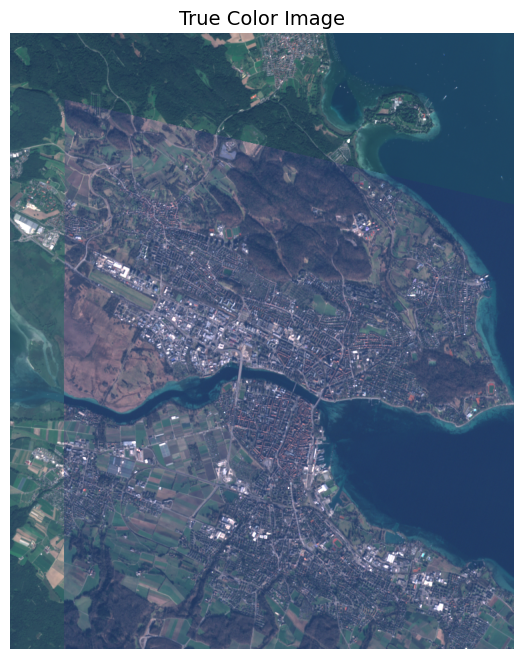

In [13]:
# Retrieve first image from all_band_responses
image = all_bands_response[0]

# Calculate intensity range for scaling and clipping
min_val = np.percentile(image, 2)  # 2nd percentile
max_val = np.percentile(image, 98)  # 98th percentile
factor = 1.0 / max_val
factor_multiplier = 1.4

# Plot the image in true color (RGB)
plot_image(
    image[:, :, [3, 2, 1]],  # Band indices for Red, Green, Blue
    factor=factor * factor_multiplier,
    clip_range=(0, 1),
    figsize=(8, 8)
)

plt.title("True Color Image", fontsize=14)
plt.show()

Sometimes, the request parameters such as the time range and `mosaicking_order` can lead to poor-quality or undesired mosaic satellite data. In such cases, you may need to manually adjust the time interval to ensure the retrieval of the desired satellite imagery, refer to Section 2.3.

The ability to directly access satellite data using a specific image ID is a promising feature that requires further exploration to fully understand its potential and implementation.


In [14]:
# Request data for the given parameters in the table "df"
request_all_bands = SentinelHubRequest(
    data_folder=download_folder,
    evalscript=evalscript_sentinel2_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c", service_url=config.sh_base_url
            ),
            time_interval='2024-08-23', ## Modify this value to filte by date
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

# Get the data
all_bands_response_v2 = request_all_bands.get_data(save_data=False)

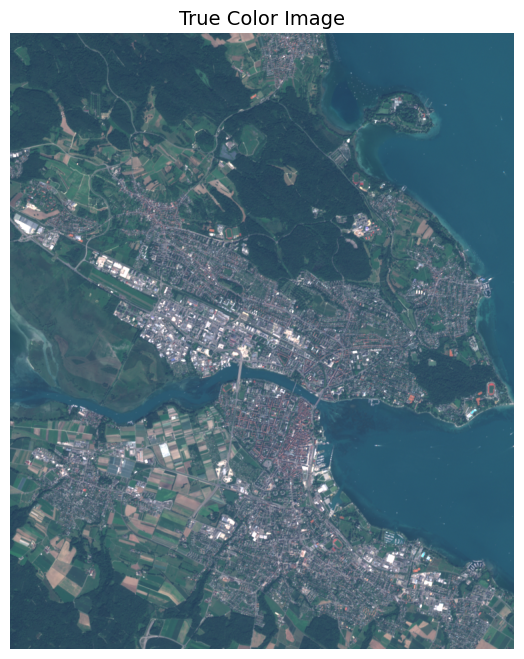

In [15]:
# Retrieve first image from all_band_responses
image = all_bands_response_v2[0]

# Calculate intensity range for scaling and clipping
min_val = np.percentile(image, 2)  # 2nd percentile
max_val = np.percentile(image, 98)  # 98th percentile
factor = 1.0 / max_val
factor_multiplier = 1.6 # Modify this to adjust overall brightness of the image

# Plot the image in true color (RGB)
plot_image(
    image[:, :, [3, 2, 1]],  # Band indices for Red, Green, Blue
    factor=factor * factor_multiplier,
    clip_range=(0, 1),
    figsize=(8, 8)
)

plt.title("True Color Image", fontsize=14)
plt.show()

#### 3. Save Image as a GeoTIFF Raster

An effective way to visualize Sentinel-2 datasets is by saving them as a GeoTIFF file locally. This format preserves geospatial metadata, making it easy to load and analyze the imagery in GIS software like QGIS or other geospatial tools.


In [16]:
import rasterio
from rasterio.transform import from_bounds
from PIL import Image

# Define the shape and transformation parameters
height, width, bands = image.shape
transform = from_bounds(*bbox_wgs84, width=width, height=height)

# Extract RGB bands and preprocess the image
rgb_image = image[:, :, [3, 2, 1]]
clipped_image = np.clip(rgb_image * factor * factor_multiplier, 0, 1)
uint8_image = (clipped_image * 255).astype(np.uint8)

temp_tif = os.path.join(download_folder, "sentinel2_data_all_bands.tif")
temp_png = os.path.join(download_folder, "sentinel2_data_rgb.png")

# Save the image as a GeoTIFF if it doesn't already exist
if not os.path.isfile(temp_tif):
    with rasterio.open(
        temp_tif,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=3,  # Only 3 bands for RGB
        dtype=uint8_image.dtype,
        crs="EPSG:4326",  # WGS84 coordinate reference system
        transform=transform,
    ) as dst:
        for i in range(3):  # Loop through the RGB bands
            dst.write(uint8_image[:, :, i], i + 1)
    print(f"GeoTIFF saved at: {temp_tif}")
    
# Save the image as a PNG file
if not os.path.isfile(temp_png):
    # Convert RGB array to PIL Image format
    pil_image = Image.fromarray(uint8_image, mode="RGB")
    pil_image.save(temp_png)
    print(f"PNG saved at: {temp_png}")

#### 4. Visualize the Saved True Color Raster Using **Folium**

Once the True Color raster is saved as a GeoTIFF file, it can be easily visualized using **Folium**.


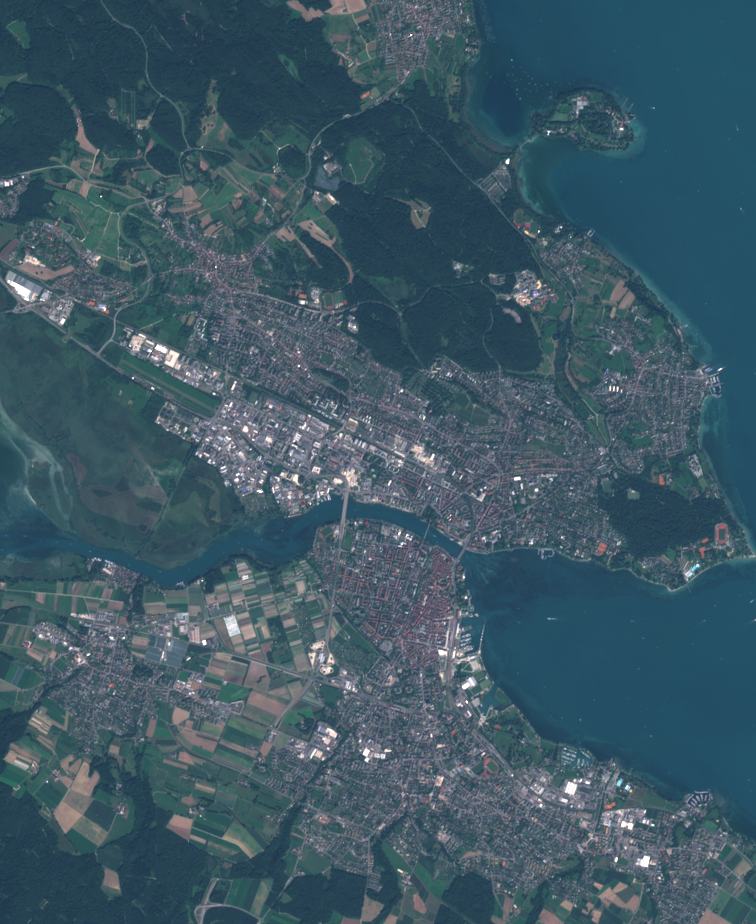

In [17]:
import folium
from folium.plugins import MiniMap, Fullscreen

# Create a Folium map
m = folium.Map(location=[(bbox_wgs84[1] + bbox_wgs84[3])/2, (bbox_wgs84[0] + bbox_wgs84[2])/2],
               zoom_start=12,
               scrollWheelZoom=False,
               )

bounds_latlon = [[bbox_wgs84[1], bbox_wgs84[0]], [bbox_wgs84[3], bbox_wgs84[2]]]

# Add raster overlay
folium.raster_layers.ImageOverlay(
    name="Sentinel-2",
    image=temp_png,
    bounds=bounds_latlon,
    opacity=1.0,
).add_to(m)

folium.LayerControl().add_to(m)

MiniMap(toggle_display=True, minimized=True).add_to(m)
Fullscreen().add_to(m)

m

#### 5. Visualize a False Color Composite Using **Matplotlib**

False color composites enhance specific features in satellite imagery, such as vegetation, water bodies, and urban areas, by using non-visible spectral bands. You can explore more about custom composite scripts and their use cases on the official [Sentinel Hub Custom Scripts Repository](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/composites/).


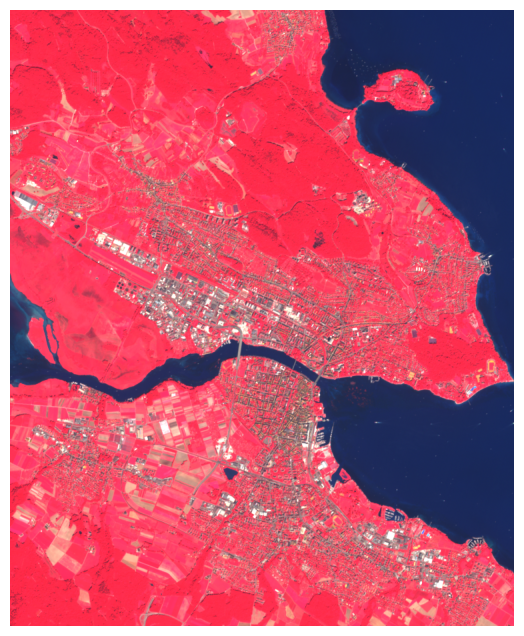

In [18]:
# Plot a false color composite using specific bands
plot_image(
    image[:, :, [7, 3, 2]],
    factor=factor*factor_multiplier,
    clip_range=(0, 1),
    figsize=(8, 8)
)

#### 6. Calculate and Plot Remote Sensing **Indices**

For more information: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel/sentinel-2/#popular-rgb-composites

##### 6.1 Normalized Difference Vegetation Index (NDVI)

NDVI masures plant health and biomass to monitor the growth and health of vegetation and to identify areas of sress or damage.

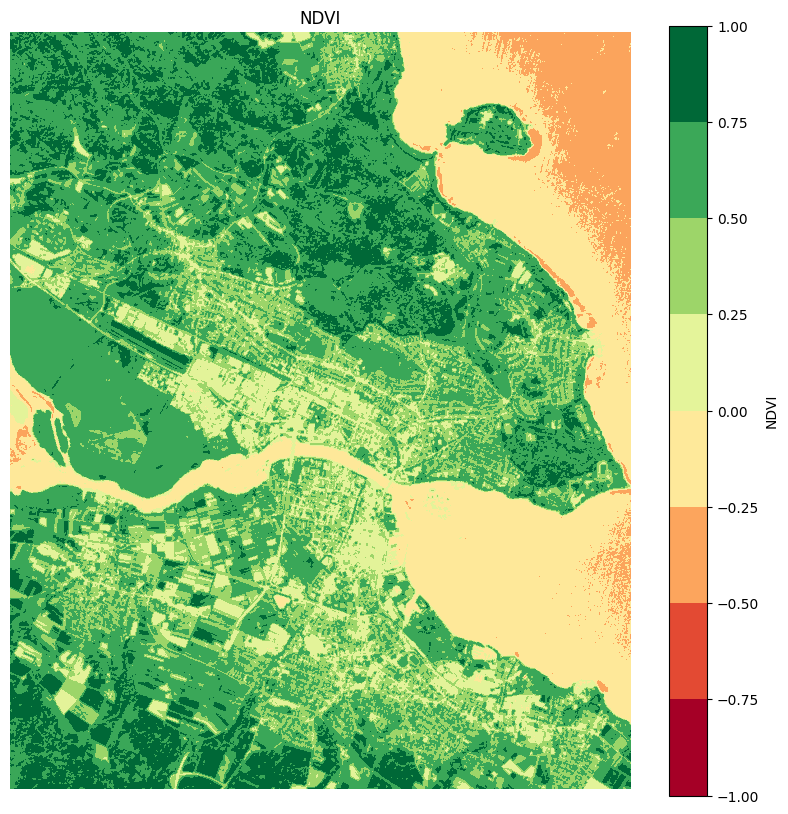

In [19]:
# Extract the NIR (Band 8) and Red (Band 4) bands
nir = all_bands_response_v2[0][:, :, 7]
red = all_bands_response_v2[0][:, :, 3]

# Compute NDVI (Add a small number to denominator to avoid division by zero)
ndvi = (nir - red) / (nir + red + 1e-10) 

# Plot NDVI
plt.figure(figsize=(10, 10))
cmap = plt.get_cmap('RdYlGn',8)
plt.imshow(ndvi, cmap=cmap, vmin=-1, vmax=1)
plt.colorbar(label='NDVI')
plt.title('NDVI')
plt.axis('off')
plt.show()

##### 6.2 Normalized Difference Moisture Index (NDMI)

NDMI is useful for monitoring vegetation water content and can be used to assess plant health, drought stress, and irrigation efficiency.

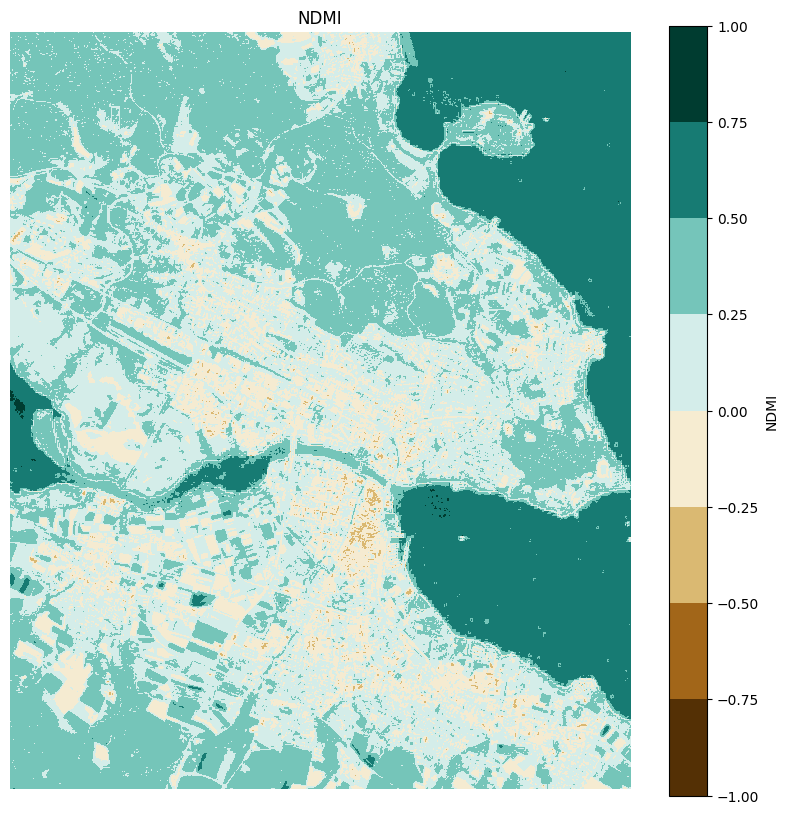

In [20]:
# Extract the NIR (Band 8) and SWIR (Band 12) bands
nir = all_bands_response_v2[0][:, :, 7]
swir = all_bands_response_v2[0][:, :, 11]

# Compute NDMI (Add a small number to denominator to avoid division by zero)
ndmi = (nir - swir) / (nir + swir + 1e-10)

# Plot NDMI
plt.figure(figsize=(10, 10))
cmap = plt.get_cmap('BrBG', 8)  # Adjusted color map for NDMI
plt.imshow(ndmi, cmap=cmap, vmin=-1, vmax=1)
plt.colorbar(label='NDMI')
plt.title('NDMI')
plt.axis('off')
plt.show()

##### 6.3 Supplements

In [21]:
## More information:

# Data for Sentinel-2 bands
data = {
    "Band Name": ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B10", "B11", "B12"],
    "Wavelength (nm)": [443, 490, 560, 665, 705, 740, 783, 842, 865, 945, 1375, 1610, 2190],
    "Resolution (m)": [60, 10, 10, 10, 20, 20, 20, 10, 20, 60, 60, 20, 20],
    "Description": [
        "Aerosol",
        "Blue",
        "Green",
        "Red",
        "Red Edge 1",
        "Red Edge 2",
        "Red Edge 3",
        "Near Infrared (NIR)",
        "Narrow NIR",
        "Water vapor",
        "Cirrus",
        "Shortwave Infrared (SWIR) - 1",
        "Shortwave Infrared (SWIR) - 2"
    ]
}

# Create a DataFrame
bands_table = pd.DataFrame(data)

# Display the table
bands_table

Band Name  Wavelength (nm)  Resolution (m)                    Description
0        B01              443              60                        Aerosol
1        B02              490              10                           Blue
2        B03              560              10                          Green
3        B04              665              10                            Red
4        B05              705              20                     Red Edge 1
5        B06              740              20                     Red Edge 2
6        B07              783              20                     Red Edge 3
7        B08              842              10            Near Infrared (NIR)
8        B8A              865              20                     Narrow NIR
9        B09              945              60                    Water vapor
10       B10             1375              60                         Cirrus
11       B11             1610              20  Shortwave Infrared (SWIR) - 1
12       B12             2190              20  Shortwave Infrared (SWIR) - 2